# Handwritting digits with TensorFlow 1.X

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import tensorflow as tf
print(tf.__version__)
!python --version

1.15.2
Python 3.7.11


In [3]:
import numpy as np
import math
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('content/gdrive/MyDrive/Colab/CV-TF1.X-2.X/data/MNIST/', one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting content/gdrive/MyDrive/Colab/CV-TF1.X-2.X/data/MNIST/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting content/gdrive/MyDrive/Colab/CV-TF1.X-2.X/data/MNIST/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting content/gdrive/MyDrive/Colab/CV-TF1.X-2.X/data/MNIST/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extractin

In [6]:
print("- Size:Training-set:\t\t{}".format(len(data.train.labels)))
print("- Size:Test-set:\t\t{}".format(len(data.test.labels)))
print("- Size:Validation-set:\t{}".format(len(data.validation.labels)))

- Size:Training-set:		55000
- Size:Test-set:		10000
- Size:Validation-set:	5000


In [7]:
#class labels for the test set
data.test.cls = np.argmax(data.test.labels, axis=1)

## Data Dimensions

In [8]:
# MNIST images are 28 pixels in each dimension.
img_size = 28

# Flattened format in 1-D array
img_size_flat = img_size * img_size

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1

# Number of classes
num_classes = 10

## Function for plotting images

In [9]:
def plot_img(images, cls_label, cls_pred=None):
    
    fig, axes = plt.subplots(1, 10, figsize=(15,15))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for idx, ax in enumerate(axes.flat):
        ax.imshow(images[idx].reshape(img_shape), cmap='binary')

        if cls_pred is None:
            label = "True: {0}".format(cls_label[idx]) # shows only the class label
        else:
            label = "True: {0}, Pred: {1}".format(cls_label[idx], cls_pred[idx])

        ax.set_xlabel(label)
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

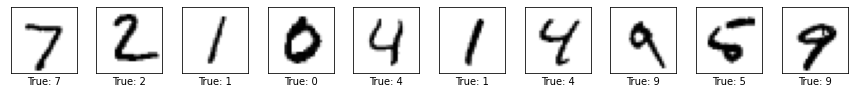

In [10]:
# Get the first images from the test-set.
images = data.test.images[0:10]

# Get the true classes for those images.
cls_true = data.test.cls[0:10]

# Plot the images and labels using the function plot_img.
plot_img(images=images, cls_label=cls_true)

## Placeholder variables

In [11]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [12]:
#The convolutional layers expect x to be encoded as a 4-dim tensor [num_images, img_height, img_width, num_channels] 
#img_height == img_width == img_size 
#num_images can be inferred automatically by using -1 for the size of the first dimension
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [13]:
# variable for the true labels associated with the images that were input in the placeholder variable x
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [14]:
#we also have a placeholder variable for the class-number, we will calculate it using argmax function.
y_true_cls = tf.argmax(y_true, axis=1)

## CNN configuration

In [15]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16        

# Convolutional Layer 2.
filter_size2 = 5          # Convolution filters are 5 x 5 pixels.
num_filters2 = 36        

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

In [16]:
# function to generate weights with random values with a given shape
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [17]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

## Creating a new Convolutional Layer

In [18]:
def conv_layer(input,              # The previous layer.
                num_input_channels, # Num. channels in prev. layer.
                filter_size,        # Width and height of each filter.
                num_filters,        # Number of filters.
                   ):

    # Shape of the filter-weights for the convolution.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # The strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME',
                         use_cudnn_on_gpu=True)

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution
    # This is 2x2 max-pooling.
    layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU)
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x))
    # we can save 75% of the relu-operations by max-pooling first.

    return layer, weights

## Flattening a layer

In [19]:
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    return layer_flat, num_features

## Creating a new Fully-Connected Layer

In [20]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the dot product of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

## Filling the layers

In [21]:
## convolutional Layer1
layer_conv1, weights_conv1 = conv_layer(input=x_image,
                           num_input_channels=num_channels,
                           filter_size=filter_size1,
                           num_filters=num_filters1,
                           )

In [22]:
layer_conv1
#(?, 14, 14, 16) which means that there is an arbitrary number of images (this is the ?)

<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [23]:
layer_conv2, weights_conv2 = conv_layer(input=layer_conv1,
                           num_input_channels=num_filters1,
                           filter_size=filter_size2,
                           num_filters=num_filters2,
                           )

In [24]:
layer_conv2
#The shape is (?, 7, 7, 36) where the ? again means that there is an arbitrary number of images.

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [25]:
#Flatten layer:
layer_flat, num_features = flatten_layer(layer_conv2)

In [26]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 1764) dtype=float32>

In [27]:
num_features

1764

In [28]:
#Fully-Connected Layer 1
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [29]:
#shape (?, 128) where the ? means there is an arbitrary number of images and fc_size == 128
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [30]:
#Fully-Connected Layer 2
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [31]:
layer_fc2

<tf.Tensor 'add_3:0' shape=(?, 10) dtype=float32>

In [32]:
#Predicted Class
y_pred = tf.nn.softmax(layer_fc2)

In [33]:
#The class-number is the index of the largest element
y_pred_cls = tf.argmax(y_pred, axis=1)

## Cost-function to be optimized

In [34]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc2, labels=y_true)
#Note that the function calculates the softmax internally so we must use the output of layer_fc2 directly
#rather than y_pred which has already had the softmax applied.

In [35]:
#we take the average of the cross-entropy for all the image classifications.
cost = tf.reduce_mean(cross_entropy)

## Optimization Method

In [36]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

## Performance Metrics

In [37]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
#a vector of booleans whether the predicted class equals the true class of each image

In [38]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
#This calculates the classification accuracy by first type-casting the vector of booleans to floats,
#so that False becomes 0 and True becomes 1, and then calculating the average of these numbers.

## TensorFlow Run

In [ ]:
#For CPU:
#session = tf.Session()
#init = session.run(tf.global_variables_initializer())

In [45]:
#For GPU:
init = tf.global_variables_initializer()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



In [39]:
train_batch_size = 64

In [40]:
total_iterations = 0
def optimize(num_iterations):
    global total_iterations

    for i in range(total_iterations, total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        # Put the batch into a dict
        feed_dict_train = {x: x_batch, y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        sess.run(optimizer, feed_dict=feed_dict_train)

        if i % 100 == 0:
            acc = sess.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))

    total_iterations += num_iterations

In [41]:
def plot_example_errors(cls_pred, correct):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    plot_img(images=images[0:10],
                cls_label=cls_true[0:10],
                cls_pred=cls_pred[0:10])

In [42]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls
    
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)
    
    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [43]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    
    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = sess.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # We define accuracy as the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Performance before any optimization 

In [46]:
print_test_accuracy()

Accuracy on Test-Set: 7.1% (706 / 10000)


## Performance after 10 optimization iterations

In [47]:
optimize(num_iterations=10)

Optimization Iteration:      1, Training Accuracy:  14.1%


In [48]:
print_test_accuracy()

Accuracy on Test-Set: 15.4% (1537 / 10000)


## Performance after 1000 optimization iterations

In [49]:
optimize(num_iterations=990)

Optimization Iteration:    101, Training Accuracy:  64.1%
Optimization Iteration:    201, Training Accuracy:  81.2%
Optimization Iteration:    301, Training Accuracy:  85.9%
Optimization Iteration:    401, Training Accuracy:  85.9%
Optimization Iteration:    501, Training Accuracy:  89.1%
Optimization Iteration:    601, Training Accuracy:  93.8%
Optimization Iteration:    701, Training Accuracy:  85.9%
Optimization Iteration:    801, Training Accuracy:  87.5%
Optimization Iteration:    901, Training Accuracy:  87.5%


Accuracy on Test-Set: 93.6% (9356 / 10000)
Example errors:


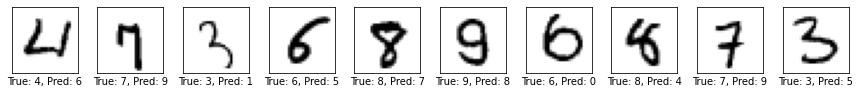

In [50]:
print_test_accuracy(show_example_errors=True)

## Performance after 10,000 optimization iterations

In [51]:
optimize(num_iterations=9000)

Optimization Iteration:   1001, Training Accuracy:  95.3%
Optimization Iteration:   1101, Training Accuracy:  90.6%
Optimization Iteration:   1201, Training Accuracy:  90.6%
Optimization Iteration:   1301, Training Accuracy:  98.4%
Optimization Iteration:   1401, Training Accuracy:  92.2%
Optimization Iteration:   1501, Training Accuracy:  89.1%
Optimization Iteration:   1601, Training Accuracy:  98.4%
Optimization Iteration:   1701, Training Accuracy:  90.6%
Optimization Iteration:   1801, Training Accuracy:  96.9%
Optimization Iteration:   1901, Training Accuracy:  93.8%
Optimization Iteration:   2001, Training Accuracy: 100.0%
Optimization Iteration:   2101, Training Accuracy:  93.8%
Optimization Iteration:   2201, Training Accuracy:  90.6%
Optimization Iteration:   2301, Training Accuracy:  95.3%
Optimization Iteration:   2401, Training Accuracy:  98.4%
Optimization Iteration:   2501, Training Accuracy:  96.9%
Optimization Iteration:   2601, Training Accuracy:  98.4%
Optimization I

Accuracy on Test-Set: 98.7% (9874 / 10000)
Example errors:


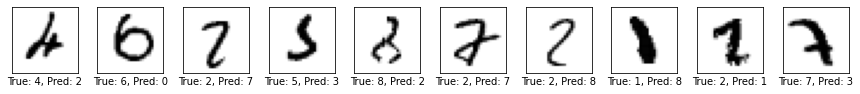

Confusion Matrix:
[[ 973    0    0    0    0    1    0    1    4    1]
 [   0 1126    1    0    1    0    2    1    4    0]
 [   3    2 1008    4    1    0    0    4    9    1]
 [   1    0    0 1005    0    0    0    1    2    1]
 [   0    0    1    0  978    0    0    1    0    2]
 [   2    0    0    5    0  877    1    1    4    2]
 [   5    3    0    0    5    2  941    0    2    0]
 [   1    1    5    1    0    0    0 1017    2    1]
 [   3    0    1    3    1    0    0    2  962    2]
 [   2    3    0    3    5    2    0    4    3  987]]


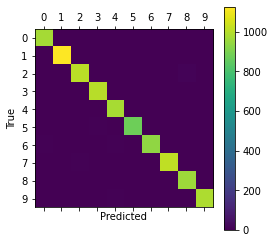

In [52]:
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

## Visualization of Weights and Layers

In [53]:
def plot_conv_weights(weights, input_channel=0):
    # Retrieve the values of the weight-variables from TensorFlow.
    # A feed-dict is not necessary because nothing is calculated.
    w = sess.run(weights)

    # Get the lowest and highest values for the weights.
    # This is used to correct the colour intensity across
    # the images so they can be compared with each other.
    w_min = np.min(w)
    w_max = np.max(w)

    num_filters = w.shape[3]# Number of filters in the conv. layer.

    # Number of grids to plot.
    # Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    # Create figure with a grid of sub-plots.
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        # Only plot the valid filter-weights.
        if i < num_filters:
            # Get the weights for the i'th filter of the input channel.
            img = w[:, :, input_channel, i]
            ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])    
    plt.show()

In [54]:
def plot_conv_layer(layer, image):
    # Create a feed-dict containing just one image.
    # Note that we don't need to feed y_true because it is
    # not used in this calculation.
    feed_dict = {x: [image]}

    # Calculate and retrieve the output values of the layer
    # when entering that image.
    values = sess.run(layer, feed_dict=feed_dict)

    # Number of filters used in the conv. layer.
    num_filters = values.shape[3]

    # Number of grids to plot. Rounded-up, square-root of the number of filters.
    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        # Only plot the images for valid filters.
        if i < num_filters:
            # Get the output image of using the i'th filter.
            img = values[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        ax.set_xticks([])
        ax.set_yticks([])    
    plt.show()

## Plotting weights, Convolutional Layers

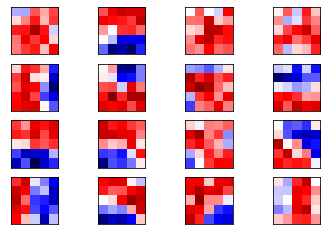

In [55]:
#Convolution Layer 1
plot_conv_weights(weights=weights_conv1)

In [56]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

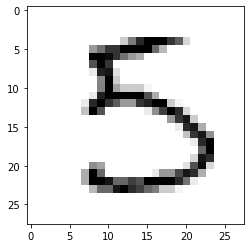

In [57]:
image1 = data.test.images[15]
plot_image(image1)

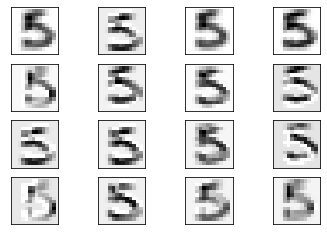

In [58]:
plot_conv_layer(layer=layer_conv1, image=image1)

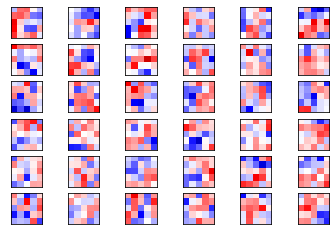

In [59]:
#There are 16 input channels to the second convolutional layer
plot_conv_weights(weights=weights_conv2, input_channel=0)

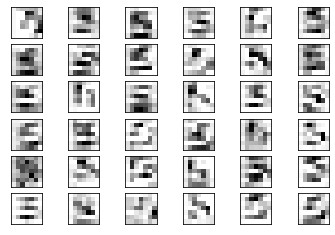

In [60]:
plot_conv_layer(layer=layer_conv2, image=image1)

In [61]:
sess.close()

## Reference:

https://www.tensorflow.org/tutorials/layers